# Entrega
## Intro
Esta notebook se utiliza para la entrega del challange. 
Explica el proceso de manera simplificada de 
- limpieza y transformacion de los datos
- entregar el modelo seleccionado, 
- eligiendo los mejores hiperparámetros
- guardando el resultado en /data/results

No se realiza un analisis, en el repositorio luego dejaré un minimo análisis.

Hay formas de asegurar la reproducibilidad de los resultados utilizando seeds (o random_state) para que el resultado sea el mismo siempre. (De todas formas, los resultados podrían diferir un poco...)

- https://machinelearningmastery.com/reproducible-machine-learning-results-by-default/
- https://machinelearningmastery.com/randomness-in-machine-learning/

______________
## Limpieza y Transformación
- El código se encuentra en funciones que realizan cambios en el dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler


SEED = 42
np.random.seed(SEED)


In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [3]:
# methods used in clean & transform stage

def train_ordinal(df, enc_columns):
    """ Train an ordinal encoder from sklearn
    """
    enc = OrdinalEncoder()
    enc.fit(df[enc_columns].to_numpy())
    
    return enc

def transform_ordinal(df, enc, enc_columns):
    """ Transform and Apply an ordinal encoder from sklearn
    """
    df[enc_columns] = enc.transform(df.loc[:, enc_columns])
    df[enc_columns] = df.loc[:, enc_columns].astype('category')
    


def train_ohe(df, ohe_columns):
    """ Train a one hot encoder from sklearn
    """
    ohe = OneHotEncoder()
    ohe.fit(df[ohe_columns])
    return ohe

def transform_one_hot(df, ohe, ohe_columns):
    """ Transform and Apply an one-hot encoder from sklearn
    """
    df.loc[:, ohe.get_feature_names(ohe_columns)] = ohe.transform(df[ohe_columns]).toarray()
    df.drop(columns=ohe_columns, inplace=True)


def train_stdscaler(df, columns):
    """ Train a scaler from sklearn. MixMax gives better performance than StandardScaler
    """
    scaler = MinMaxScaler()
    scaler.fit(df[columns])
    return scaler

def transform_stdscaler(df, scaler, columns):
    """ Transform and Apply scaler from sklearn
    """
    df[columns] = scaler.transform(df[columns])
    

def sum_duration_columns(df):
    """ From all *_Duration columns, it are sum and result in a new column Total
    """
    duration_columns = df.columns.str.contains("Duration")
    duration_columns_str = df.columns[duration_columns]
    pages_names = duration_columns_str.str.replace('_Duration', '')
    df['Total_Duration'] = df.loc[:, duration_columns_str].sum(axis=1)
    df["Total"] = df.loc[:, pages_names].sum(axis=1)

def avg_duration_per_page(df):
    """ From all *_Duration columns, add a avg duration time per page
    """
    duration_columns = df.columns.str.contains("Duration")
    duration_columns_str = df.columns[duration_columns]
    pages_names = duration_columns_str.str.replace('_Duration', '')
    for page, duration in zip(pages_names, duration_columns_str):
        df[page+"_Duration_AVG"]= (df[duration] / df[page]).fillna(-1)


In [4]:
# transforming TRAIN set

enc_columns=["Month", "TrafficType", "Browser", "SpecialDay", "OperatingSystems", "Region", "VisitorType", "Weekend"]
enc = train_ordinal(train, enc_columns)
transform_ordinal(train, enc, enc_columns)

sum_duration_columns(train)
avg_duration_per_page(train)

stdscaler_columns = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]

scaler = train_stdscaler(train, stdscaler_columns)
transform_stdscaler(train, scaler, stdscaler_columns)

In [5]:
# transform TEST set 
transform_ordinal(test, enc, enc_columns)
transform_stdscaler(test, scaler, stdscaler_columns)

sum_duration_columns(test)
avg_duration_per_page(test)



_______________________
## Model: Selecting, Training and Tuning


In [6]:
import pandas as pd

In [7]:
import lightgbm as lgb
import optuna

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer

from functools import partial

In [9]:
metric = partial(f1_score, average='macro')
score = make_scorer(f1_score, average='macro')

In [10]:
X, y = train.loc[:, ~train.columns.isin(['revenue', "id"])], train.revenue
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=SEED)

### Selecting model

In [31]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
import warnings
warnings.simplefilter('ignore')

clf1 = lgb.LGBMClassifier(random_state=SEED)
clf2 = KNeighborsClassifier()
clf3 = RandomForestClassifier(random_state=SEED)

lr = LogisticRegression(random_state=SEED)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['LGB1',  'KNN', 'RF', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring=score)
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))
    

3-fold cross validation:

Accuracy: 0.7958 (+/- 0.0120) [LGB1]
Accuracy: 0.6653 (+/- 0.0044) [KNN]
Accuracy: 0.7926 (+/- 0.0029) [RF]
Accuracy: 0.7926 (+/- 0.0029) [StackingClassifier]


probando algunos modelos, nos damos cuenta que lgb o rf pueden ser una buena opción.

En este caso voy a elegir LightGBM, pero podría agregar un branch con `trial.suggest_categorical("model", ["lgb", "rf"])`

In [38]:
def objective_challenge(trial):

    param = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.06, 0.08),
        "n_estimators":trial.suggest_int("n_estimators", 300, 400, step=50),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "random_state": trial.suggest_int("random_state", SEED, SEED),
        "verbosity": trial.suggest_int("verbosity", -1, -1),
        "boosting_type": trial.suggest_categorical("boosting", ["goss", "dart"]),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 9, 27, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 12, 256),
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True]),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "F1_MACRO", "validation")

    gbm = lgb.LGBMClassifier(**param, verbose=0)
    
    f1_cross = cross_val_score(
        gbm, 
        pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), 
        cv=StratifiedKFold(2), 
        scoring=score,
        fit_params={
            **fit_params, 
#             "early_stopping_rounds":15, 
            "callbacks":[pruning_callback]
        }
    )
    
    return np.mean(f1_cross)
    
    # if performance is lower as expected, comment above code and uncomment this part.
#     gbm.fit(X_train, y_train, **fit_params, early_stopping_rounds=10)
#     return metric(y_val, gbm.predict(X_val))

fit_params = {
    "eval_set":[(X_train, y_train), (X_val, y_val)], 
    "eval_names":["train", "validation"],
#     "early_stopping_rounds":20,
    "eval_metric":[lambda y_true, y_pred: ("F1_MACRO", metric(y_true, np.round(y_pred)), True)],
    "feature_name":X_train.columns.tolist(),
    "categorical_feature":["Month", "TrafficType", "Browser", "SpecialDay", "OperatingSystems", "Region", "VisitorType", "Weekend"]
}

In [39]:
# creamos un study de optuna para buscar los mejores parámetros de lightgbm
study = optuna.create_study(
    study_name="005-study-challenge",
    storage="sqlite:///005-study-challenge.db",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=20, n_warmup_steps=30), # this acts as a early_stopping
    direction="maximize",
    load_if_exists=True
)

study.optimize(objective_challenge, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-02-08 18:18:39,912] Using an existing study with name '005-study-challenge' instead of creating a new one.


[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[1]	train's binary_logloss: 0.391956	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389154	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366641	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362987	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348624	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343706	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335003	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328727	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324702	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31721	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315991	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30755	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308793	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299499

[W 2021-02-08 18:18:46,324] Trial 488 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389988	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387032	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364316	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36077	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346236	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341379	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332704	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327017	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321945	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314758	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313482	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305356	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314486	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306437	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307141	train's F1_MACRO: 0.458158

[W 2021-02-08 18:18:56,627] Trial 489 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390288	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387874	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365232	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36183	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347754	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3437	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334429	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329032	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323793	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317418	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315853	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308173	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.30921	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300709	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303731	train's F1_MACRO: 0.759036	va

[W 2021-02-08 18:19:01,906] Trial 490 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389945	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387396	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364351	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360942	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346269	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341755	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332687	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326753	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322326	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315142	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313927	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305119	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314844	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306034	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307706	train's F1_MACRO: 0.45815

[W 2021-02-08 18:19:05,891] Trial 491 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392598	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.390955	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.368366	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.365746	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.350463	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.346431	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.337014	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.332235	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32672	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.320656	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.318706	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311478	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.31159	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.303363	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.306031	train's F1_MACRO: 0.723967	

[W 2021-02-08 18:19:09,371] Trial 492 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390005	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387166	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364387	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360957	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346256	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.34183	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332709	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326865	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322341	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315478	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31417	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305868	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307472	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297583	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301923	train's F1_MACRO: 0.782451	

[W 2021-02-08 18:19:13,027] Trial 493 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392024	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389287	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366992	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36362	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349076	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344761	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335512	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329854	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324946	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318356	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316698	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308799	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309771	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301039	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30422	train's F1_MACRO: 0.713502	

[W 2021-02-08 18:19:16,931] Trial 494 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389972	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387136	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364328	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360903	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346182	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341761	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332617	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326779	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322239	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315381	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31406	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305761	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315019	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306644	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307957	train's F1_MACRO: 0.458158

[W 2021-02-08 18:19:20,911] Trial 495 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390116	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387231	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364453	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360886	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346365	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341487	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332853	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327179	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322001	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314645	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313549	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305388	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.31455	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306486	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307656	train's F1_MACRO: 0.458158

[W 2021-02-08 18:19:24,940] Trial 496 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392068	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389295	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366985	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363567	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349142	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344718	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335543	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329778	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32498	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318158	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316214	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30853	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317325	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309606	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310486	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:19:28,993] Trial 497 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389873	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386901	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364169	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.359934	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345926	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340371	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332367	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325301	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321957	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314016	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31363	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304689	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314356	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305658	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.306872	train's F1_MACRO: 0.458158

[W 2021-02-08 18:19:32,544] Trial 498 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390187	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387772	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365144	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36174	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.3477	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343652	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334474	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329078	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324565	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318339	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316708	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309462	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317504	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310232	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311054	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:19:35,122] Trial 499 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389929	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387082	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364259	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360819	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34611	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341436	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332647	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.32715	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321974	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315069	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313976	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305723	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307028	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297694	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301526	train's F1_MACRO: 0.75934	v

[W 2021-02-08 18:19:38,450] Trial 500 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39071	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388995	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365904	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363169	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347838	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343624	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33473	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329414	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324819	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318712	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31685	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309587	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318118	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311336	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311085	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:19:41,767] Trial 501 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389965	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387017	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364089	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360312	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345962	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341412	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332444	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326736	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321599	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314391	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313062	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304785	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306296	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.296846	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301015	train's F1_MACRO: 0.75888

[W 2021-02-08 18:19:44,681] Trial 502 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390989	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387952	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365027	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361083	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345942	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340018	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332021	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.324358	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.320824	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311586	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.311349	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301016	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.304073	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.292488	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.298359	train's F1_MACRO: 0.74390

[W 2021-02-08 18:19:47,075] Trial 503 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392064	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389713	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367445	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364058	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349701	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345331	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336318	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330668	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325765	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319129	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317639	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309437	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318462	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310352	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311189	train's F1_MACRO: 0.45815

[W 2021-02-08 18:19:51,337] Trial 504 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390845	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389291	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366581	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364381	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349436	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.346165	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336532	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.332347	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.326553	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.321388	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.319311	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313138	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.320255	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314225	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.314119	train's F1_MACRO: 0.45815

[W 2021-02-08 18:19:53,758] Trial 505 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389978	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387512	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364756	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361283	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34668	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342228	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333467	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327859	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322897	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316283	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31453	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305894	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307695	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.298345	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302153	train's F1_MACRO: 0.753928	

[W 2021-02-08 18:19:55,810] Trial 506 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390045	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387208	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364438	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361011	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346309	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341886	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332758	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326917	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322386	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315526	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314208	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30591	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307505	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297619	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301949	train's F1_MACRO: 0.782451

[W 2021-02-08 18:19:58,422] Trial 507 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392134	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389798	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367499	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364135	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349918	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345834	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336554	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.331753	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325896	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.320127	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317346	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309662	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318074	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310362	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311078	train's F1_MACRO: 0.45815

[W 2021-02-08 18:20:01,879] Trial 508 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389895	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386853	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.363783	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.359764	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.3449	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.339409	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33116	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.324074	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.320584	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.312158	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.311684	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.302365	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.304869	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.294674	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.299274	train's F1_MACRO: 0.768928	v

[W 2021-02-08 18:20:04,409] Trial 509 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389978	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387044	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364307	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360775	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346025	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341019	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33225	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326376	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321475	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313964	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.312977	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304392	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314108	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3057	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307221	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:20:07,723] Trial 510 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390134	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387694	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365029	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361594	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347541	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343439	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334208	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328786	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323733	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317381	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315758	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308108	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316261	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308548	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309691	train's F1_MACRO: 0.45815

[W 2021-02-08 18:20:12,918] Trial 511 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390057	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387601	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364857	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361397	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346785	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342351	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333581	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328186	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322849	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316319	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314694	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306577	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315612	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307555	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308649	train's F1_MACRO: 0.45815

[W 2021-02-08 18:20:17,006] Trial 512 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390015	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387562	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36487	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361414	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346952	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342469	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333843	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328416	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323279	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316716	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315547	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307741	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308718	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300217	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30331	train's F1_MACRO: 0.757889	

[W 2021-02-08 18:20:21,411] Trial 513 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392695	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.391091	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.368698	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.366263	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.350965	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.346981	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.337932	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.333267	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.327209	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.321358	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.319023	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311896	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.312149	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304266	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.3064	train's F1_MACRO: 0.734361	

[W 2021-02-08 18:20:26,502] Trial 514 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390004	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387154	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364381	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360936	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346257	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341577	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332822	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327318	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322161	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315249	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314169	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305912	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315023	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306931	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308004	train's F1_MACRO: 0.45815

[W 2021-02-08 18:20:30,764] Trial 515 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39068	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388999	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36613	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363588	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348112	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344137	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33476	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329474	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324961	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318947	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317283	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310078	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318465	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311788	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311426	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:20:34,314] Trial 516 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392058	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389727	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.3674	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364028	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34983	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345782	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336406	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.33158	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325457	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319225	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31725	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309493	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318004	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310158	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310812	train's F1_MACRO: 0.458158	val

[W 2021-02-08 18:20:37,756] Trial 517 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389952	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387014	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364077	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360315	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345817	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340717	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332079	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325481	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321522	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31381	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.312935	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304261	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314076	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30553	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.306912	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:20:41,416] Trial 518 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391978	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389168	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366655	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362988	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348623	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.34368	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334981	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328674	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324613	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317129	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315861	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307439	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308646	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.29937	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303098	train's F1_MACRO: 0.734361	

[W 2021-02-08 18:20:44,668] Trial 519 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390239	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387813	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36512	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361704	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347393	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343231	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334213	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328811	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323686	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317335	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31562	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307666	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316312	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308375	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309234	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:20:48,065] Trial 520 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389889	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387034	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364228	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360777	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346093	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341404	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332658	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327144	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322003	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31508	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314021	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305751	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307236	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297977	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301738	train's F1_MACRO: 0.75934	

[W 2021-02-08 18:20:51,293] Trial 521 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389891	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386937	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364045	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360262	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345823	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340703	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332262	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325658	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321746	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314031	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313189	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30451	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314252	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305685	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307115	train's F1_MACRO: 0.458158

[W 2021-02-08 18:20:54,826] Trial 522 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390572	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388129	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365214	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361925	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347129	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342849	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333548	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327867	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323156	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316252	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314905	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306567	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315958	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307563	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308767	train's F1_MACRO: 0.45815

[W 2021-02-08 18:20:58,083] Trial 523 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389784	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386796	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.363877	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.359838	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345834	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340171	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.331791	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.324816	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321406	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313045	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313152	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.303752	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.313924	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304619	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.306714	train's F1_MACRO: 0.45815

[W 2021-02-08 18:21:01,593] Trial 524 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391982	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389249	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367025	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363742	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349103	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344877	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335621	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.33004	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32506	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318462	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316569	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309021	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317754	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310187	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310839	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:21:04,897] Trial 525 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391993	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389177	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366652	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362942	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348618	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343671	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33499	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328674	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324623	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317244	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316152	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308042	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317013	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309131	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309923	train's F1_MACRO: 0.458158

[W 2021-02-08 18:21:08,325] Trial 526 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392059	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389696	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367457	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364055	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349633	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345306	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336204	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330125	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325825	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318981	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31752	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309793	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310646	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301804	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.304955	train's F1_MACRO: 0.733091

[W 2021-02-08 18:21:11,685] Trial 527 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390027	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387565	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36483	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361363	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346767	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342324	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33358	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328176	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323019	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316609	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314666	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306246	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307838	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.298694	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302277	train's F1_MACRO: 0.753928	

[W 2021-02-08 18:21:15,167] Trial 528 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392098	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389318	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366821	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363298	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348818	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344037	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335269	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329131	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324711	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317564	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316014	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307938	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.31722	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309229	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310392	train's F1_MACRO: 0.458158

[W 2021-02-08 18:21:18,643] Trial 529 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389986	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387534	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364772	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361316	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346807	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342314	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333618	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328166	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322994	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316387	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314867	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306677	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308008	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299048	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302635	train's F1_MACRO: 0.75788

[W 2021-02-08 18:21:22,385] Trial 530 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390029	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38708	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364206	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360394	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345995	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340892	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332446	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325861	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322162	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314496	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313894	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305466	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314671	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306483	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307792	train's F1_MACRO: 0.458158

[W 2021-02-08 18:21:30,035] Trial 531 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391906	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388977	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366463	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36257	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347721	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342153	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33393	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327021	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322919	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314645	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314004	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304559	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306986	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.296386	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301242	train's F1_MACRO: 0.745126	

[W 2021-02-08 18:21:36,252] Trial 532 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389969	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387035	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364301	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360664	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345889	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341443	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332407	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.32681	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321627	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31448	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313158	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304943	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306658	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297491	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301095	train's F1_MACRO: 0.75888	v

[W 2021-02-08 18:21:40,827] Trial 533 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390084	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387549	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364533	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361143	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34646	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341971	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332871	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326969	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322498	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315351	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314085	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30532	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.30752	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297565	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301776	train's F1_MACRO: 0.780407	v

[W 2021-02-08 18:21:46,525] Trial 534 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39202	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389241	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366919	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363494	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349048	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344579	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335451	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.32964	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324889	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318016	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316124	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308386	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317168	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309403	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310466	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:21:50,193] Trial 535 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390008	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387063	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364338	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360805	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346255	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341416	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332497	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326713	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321742	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314551	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313116	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30497	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306394	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.296901	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.3011	train's F1_MACRO: 0.75934	va

[W 2021-02-08 18:21:53,573] Trial 536 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389928	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387484	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364696	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361248	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346716	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342303	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33348	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328141	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322919	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316585	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314743	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306977	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315354	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307572	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308351	train's F1_MACRO: 0.458158

[W 2021-02-08 18:21:57,493] Trial 537 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39211	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389323	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366823	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36319	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348798	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343901	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335146	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328897	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324817	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317344	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316075	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307653	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308863	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299552	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303298	train's F1_MACRO: 0.734361	

[W 2021-02-08 18:22:01,100] Trial 538 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392777	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.390492	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.368493	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.365282	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.351018	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.347112	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.337544	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.33309	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32713	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.321803	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.318917	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.312802	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.311951	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305066	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30612	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:22:04,875] Trial 539 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390092	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387629	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364951	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361485	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346924	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342485	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333697	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327818	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323303	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316602	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314964	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307205	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308237	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299173	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302804	train's F1_MACRO: 0.74631

[W 2021-02-08 18:22:08,760] Trial 540 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39065	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388932	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365788	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363039	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347673	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343443	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334221	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329207	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323547	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317117	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31507	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307543	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308981	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300721	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303348	train's F1_MACRO: 0.741527	

[W 2021-02-08 18:22:15,123] Trial 541 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39201	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389216	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366707	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363165	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348699	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343891	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335156	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328984	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324608	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31742	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315917	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307799	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309057	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299867	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303416	train's F1_MACRO: 0.734361	

[W 2021-02-08 18:22:21,150] Trial 542 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390803	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389121	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366228	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363672	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348177	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344206	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334791	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.33004	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324474	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318459	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316272	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309367	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.31743	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310868	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310398	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:22:26,380] Trial 543 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390079	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387591	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364709	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361093	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346611	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.34202	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333104	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.32708	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322593	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315636	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314362	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306378	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315499	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30749	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308978	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:22:31,955] Trial 544 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390681	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387771	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364978	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360915	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346162	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340932	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332345	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325358	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321551	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313321	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.312712	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30282	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.305803	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.295192	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.29995	train's F1_MACRO: 0.74074	v

[W 2021-02-08 18:22:35,980] Trial 545 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389982	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387485	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364577	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360948	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346467	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341859	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332956	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326908	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32278	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315597	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314321	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30624	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315441	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307341	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308985	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:22:39,941] Trial 546 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390164	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387706	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365014	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36156	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347073	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342672	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333865	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328556	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323318	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317031	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315106	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307229	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308276	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.299783	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302839	train's F1_MACRO: 0.753601

[W 2021-02-08 18:22:44,637] Trial 547 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391418	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389778	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367086	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364594	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349368	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345345	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336051	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330858	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325765	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319706	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317678	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310358	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318892	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.312053	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311817	train's F1_MACRO: 0.45815

[W 2021-02-08 18:22:50,906] Trial 548 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392676	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.390361	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.368223	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364881	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.350526	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.346213	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.337097	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.331564	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.326338	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319779	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317995	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309886	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310848	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.302074	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.304895	train's F1_MACRO: 0.72002

[W 2021-02-08 18:22:56,546] Trial 549 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390047	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387592	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364931	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361473	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346999	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342418	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333932	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328405	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323475	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316973	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315373	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307439	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316406	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308595	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309413	train's F1_MACRO: 0.45815

[W 2021-02-08 18:23:00,855] Trial 550 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392155	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389394	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367094	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363694	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349255	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344854	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335647	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329912	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325111	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318399	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316844	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308808	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309713	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300835	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303902	train's F1_MACRO: 0.73436

[W 2021-02-08 18:23:05,028] Trial 551 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392036	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38915	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366637	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362806	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348379	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343421	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334173	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327988	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323506	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316048	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314875	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306272	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315844	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306849	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308499	train's F1_MACRO: 0.458158

[W 2021-02-08 18:23:08,995] Trial 552 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390009	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387142	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364387	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360934	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346254	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341808	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332695	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326837	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322242	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315305	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313929	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305487	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307226	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297169	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301667	train's F1_MACRO: 0.78245

[W 2021-02-08 18:23:12,995] Trial 553 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389807	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386849	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.363931	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360142	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345698	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340569	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332134	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325519	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32162	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313892	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313066	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304381	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.30642	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.29658	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.300852	train's F1_MACRO: 0.75934	va

[W 2021-02-08 18:23:16,549] Trial 554 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390034	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387543	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364617	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360994	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34648	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341878	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332925	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326882	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322329	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31512	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313941	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305941	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307288	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.298335	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30233	train's F1_MACRO: 0.759644	v

[W 2021-02-08 18:23:20,282] Trial 555 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390341	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387963	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365374	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362018	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348061	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344193	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334747	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329605	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324952	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318995	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316823	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310048	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310801	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.303205	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.305409	train's F1_MACRO: 0.75792

[W 2021-02-08 18:23:24,107] Trial 556 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392134	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389375	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367065	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363667	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349222	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344824	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335613	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329881	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324993	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318086	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316802	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308693	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309704	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30101	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303946	train's F1_MACRO: 0.735627

[W 2021-02-08 18:23:28,909] Trial 557 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389972	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387504	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364795	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361326	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346834	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342256	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333735	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328222	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323191	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316549	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315487	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307613	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316316	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308588	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309411	train's F1_MACRO: 0.45815

[W 2021-02-08 18:23:33,456] Trial 558 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392008	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389208	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36671	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363159	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348707	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343888	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335172	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328986	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32463	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317426	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315942	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307807	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317142	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309093	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310326	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:23:37,756] Trial 559 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390669	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38895	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365816	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363066	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347707	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343475	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33426	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329244	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323588	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317156	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315112	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307583	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316217	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309037	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309379	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:23:42,393] Trial 560 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392002	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389604	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367055	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363763	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349143	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3449	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335653	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330052	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325248	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318619	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316993	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309062	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.317917	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.310042	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.31085	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:23:47,459] Trial 561 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389956	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386992	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364238	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360015	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346105	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341131	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332605	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.32645	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32237	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31501	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313706	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304742	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306488	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.296787	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.300966	train's F1_MACRO: 0.760608	v

[W 2021-02-08 18:23:51,709] Trial 562 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390205	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387796	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365054	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361656	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347299	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343159	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33411	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328875	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323361	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317077	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315287	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307693	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309083	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300459	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303704	train's F1_MACRO: 0.759036

[W 2021-02-08 18:23:56,216] Trial 563 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39203	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3897	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367391	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364027	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349665	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345478	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336408	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.331251	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325667	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319512	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317131	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309054	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310073	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301287	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.304657	train's F1_MACRO: 0.723967	v

[W 2021-02-08 18:24:00,411] Trial 564 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390028	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387191	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364461	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361033	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346373	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341954	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332885	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327054	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322558	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315726	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314787	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306541	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308022	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.29913	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302821	train's F1_MACRO: 0.758502

[W 2021-02-08 18:24:04,564] Trial 565 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.393278	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3917	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.369507	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.367354	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.352385	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.349365	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.339093	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.335473	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.328713	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.323942	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.320405	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314562	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.313809	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307195	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308222	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:24:08,777] Trial 566 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392137	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389779	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367683	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.364377	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.350095	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345841	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336642	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.331384	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.326105	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.319792	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.318021	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31062	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.311046	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.302908	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30535	train's F1_MACRO: 0.733091	

[W 2021-02-08 18:24:13,721] Trial 567 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39049	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388776	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365692	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362972	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34784	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343909	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334984	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330074	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324884	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318739	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317119	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309994	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.318061	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.311076	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.311168	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:24:18,796] Trial 568 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390029	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387547	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364629	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361017	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346507	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.34192	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332972	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326952	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32244	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315486	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314191	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306193	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315303	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307233	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.308477	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:24:25,374] Trial 569 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392285	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.390637	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.368489	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.366264	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.351366	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.347869	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.33922	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.335192	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.329383	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.324244	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.321899	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315878	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.322736	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316977	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.316052	train's F1_MACRO: 0.458158

[W 2021-02-08 18:24:31,088] Trial 570 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392072	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.3893	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366984	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363569	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349114	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344659	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335513	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329717	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324944	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318089	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316173	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308454	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309337	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300573	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30378	train's F1_MACRO: 0.734361	v

[W 2021-02-08 18:24:35,047] Trial 571 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390091	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387633	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364978	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361518	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347075	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342588	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334069	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328339	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323746	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317178	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315462	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307839	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308819	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300151	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303443	train's F1_MACRO: 0.74179

[W 2021-02-08 18:24:39,356] Trial 572 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390031	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387098	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364223	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360469	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346009	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340929	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332439	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325886	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.32191	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314255	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313343	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304735	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.314485	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305994	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.307283	train's F1_MACRO: 0.458158

[W 2021-02-08 18:24:44,572] Trial 573 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.392049	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389695	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.367392	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363993	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.349532	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.345206	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.336118	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.33051	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.325546	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318945	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.317267	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309092	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310275	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301526	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.304396	train's F1_MACRO: 0.720023

[W 2021-02-08 18:24:49,301] Trial 574 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391953	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.389145	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366615	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362952	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348575	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343636	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334926	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328624	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324555	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317076	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.315803	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307386	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316997	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308678	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309455	train's F1_MACRO: 0.45815

[W 2021-02-08 18:24:53,889] Trial 575 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390622	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38889	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365348	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.36174	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347489	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343108	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334079	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328957	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323102	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316441	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314768	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306989	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.315753	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308016	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.309301	train's F1_MACRO: 0.458158	

[W 2021-02-08 18:24:56,779] Trial 576 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389824	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.386881	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364105	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360457	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.345677	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341214	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332192	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326576	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321417	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314247	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.312957	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304716	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306486	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297234	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.300934	train's F1_MACRO: 0.75888

[W 2021-02-08 18:24:59,210] Trial 577 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390017	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387074	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364329	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360696	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346144	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341075	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332561	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326674	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321826	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314382	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313274	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304913	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306213	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.296243	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.300852	train's F1_MACRO: 0.75934

[W 2021-02-08 18:25:02,315] Trial 578 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390027	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387441	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364459	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360916	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346384	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341743	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332789	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326737	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322197	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314763	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313613	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305221	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306914	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.297585	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301565	train's F1_MACRO: 0.78217

[W 2021-02-08 18:25:05,095] Trial 579 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389995	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387493	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364592	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360959	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346484	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.341869	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332974	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.326917	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322797	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315603	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314336	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306244	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307599	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.298789	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302536	train's F1_MACRO: 0.75850

[W 2021-02-08 18:25:07,829] Trial 580 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.391204	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.388798	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.366363	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.362987	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.348657	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.344501	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.335087	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.330145	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324603	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318634	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316044	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308613	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.309406	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.300895	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303631	train's F1_MACRO: 0.74029

[W 2021-02-08 18:25:10,895] Trial 581 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389914	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387414	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.36468	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361175	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346605	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342123	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333135	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327318	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.322452	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.315397	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.314339	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305915	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.31538	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306897	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.30825	train's F1_MACRO: 0.458158	v

[W 2021-02-08 18:25:13,828] Trial 582 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390182	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387742	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365148	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361716	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347718	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343629	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334433	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329033	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324122	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.317804	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316126	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.308639	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.316943	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.309422	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.310574	train's F1_MACRO: 0.45815

[W 2021-02-08 18:25:16,989] Trial 583 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390076	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38715	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364268	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.360523	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346046	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.340976	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.332459	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.325919	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.321915	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.314271	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.313336	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.304739	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.306633	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.29679	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.301048	train's F1_MACRO: 0.75934	v

[W 2021-02-08 18:25:18,993] Trial 584 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.390753	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.38906	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.365906	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.363193	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.347858	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.343771	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.334628	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.329693	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.324637	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.318903	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.316676	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.30988	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.310055	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.301742	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.305146	train's F1_MACRO: 0.748573	

[W 2021-02-08 18:25:21,263] Trial 585 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.39004	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387563	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364836	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361358	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.34686	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342418	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333609	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.328242	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323025	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316663	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.3145	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.306641	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.307801	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.298907	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.302373	train's F1_MACRO: 0.753601	va

[W 2021-02-08 18:25:23,065] Trial 586 failed, because the objective function returned nan.


[1]	train's binary_logloss: 0.389905	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387412	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.364753	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.361248	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.346747	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.342264	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.333594	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.327667	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.323431	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.316572	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.31515	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.307281	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.308277	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.29943	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.303239	train's F1_MACRO: 0.761017	

[W 2021-02-08 18:25:25,105] Trial 587 failed, because the objective function returned nan.


Number of finished trials: 588
Best trial:
  Value: 0.8051595695739754
  Params: 
    boosting_type: goss
    is_unbalance: True
    learning_rate: 0.06872519914585512
    max_depth: 25
    n_estimators: 350
    num_leaves: 229
    objective: binary
    random_state: 42
    reg_alpha: 1.9709507151338186
    reg_lambda: 0.13337550535433135
    verbosity: -1


In [41]:
print("Best params", trial.params)

Best params {'boosting_type': 'goss', 'is_unbalance': True, 'learning_rate': 0.06872519914585512, 'max_depth': 25, 'n_estimators': 350, 'num_leaves': 229, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 1.9709507151338186, 'reg_lambda': 0.13337550535433135, 'verbosity': -1}


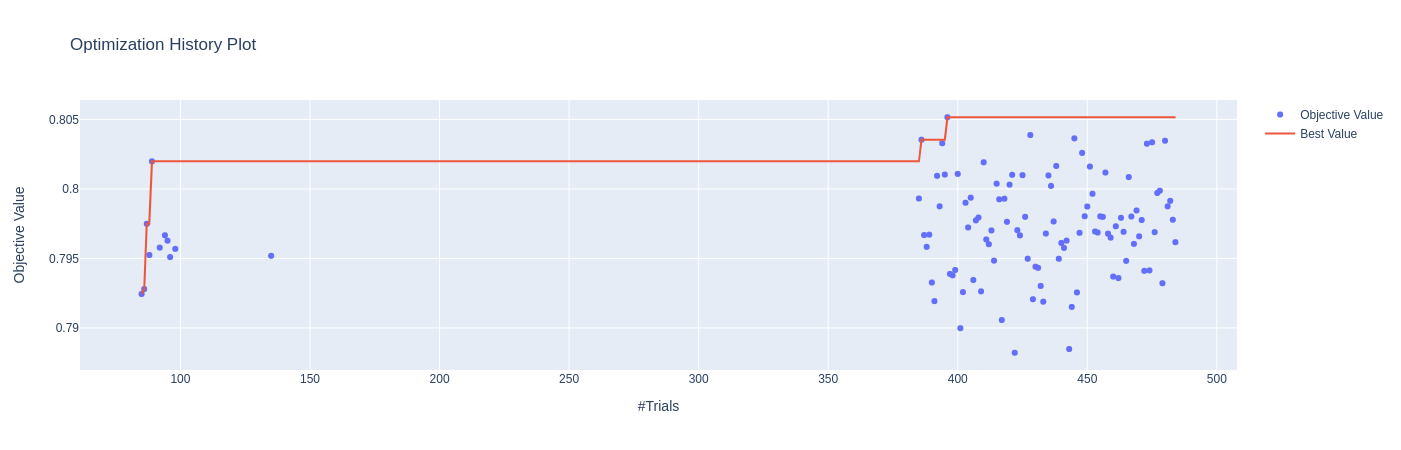

In [54]:
# jupyter lab needs plotly extension widget
# https://github.com/plotly/plotly.py#jupyterlab-support-python-35
# https://colab.research.google.com/github/optuna/optuna/blob/master/examples/quickstart.ipynb#scrollTo=Jd4Ew4Kt_IIm
optuna.visualization.plot_optimization_history(study)
#     optuna.visualization.plot_param_importances(study)
# optuna.visualization.matplotlib.plot_param_importances(study)
# for t in study.get_trials():
#     if t.values is None:
#         t.values=[0] 


In [55]:
records = []
for t in study.get_trials():
    records.append({**t.params, "f1_score":t.values[0] if t.values is not None else 0})

pd.DataFrame.from_records(records).sort_values(by="f1_score", ascending=False)

,boosting_type,is_unbalance,learning_rate,max_depth,n_estimators,num_leaves,objective,random_state,reg_alpha,reg_lambda,verbosity,f1_score,boosting
396,goss,True,0.068725,25.0,350.0,229.0,binary,42.0,1.970951,0.133376,-1.0,0.805160,NaN
428,goss,True,0.066550,16.0,400.0,206.0,binary,42.0,1.867187,0.014528,-1.0,0.803880,NaN
445,goss,True,0.074635,9.0,350.0,16.0,binary,42.0,1.898856,0.424786,-1.0,0.803641,NaN
386,goss,True,0.072302,11.0,350.0,19.0,binary,42.0,0.709896,1.059122,-1.0,0.803544,NaN
480,goss,True,0.069141,9.0,350.0,219.0,binary,42.0,1.203379,0.949287,-1.0,0.803469,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,goss,True,0.070394,9.0,350.0,23.0,binary,42.0,0.666140,0.774417,-1.0,0.000000,NaN
205,goss,True,0.070091,9.0,350.0,188.0,binary,42.0,1.722385,1.640259,-1.0,0.000000,NaN
206,goss,True,0.050462,9.0,350.0,28.0,binary,42.0,1.064946,1.624555,-1.0,0.000000,NaN
207,goss,True,0.070093,9.0,350.0,34.0,binary,42.0,0.126135,1.629529,-1.0,0.000000,NaN


In [59]:
study.trials_dataframe()[lambda r: r.value.notna()].sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_boosting,params_boosting_type,params_is_unbalance,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,params_objective,params_random_state,params_reg_alpha,params_reg_lambda,params_verbosity,state
396,396,0.805160,2021-02-08 17:11:38.718184,2021-02-08 17:11:40.638702,0 days 00:00:01.920518,NaN,goss,True,0.068725,25.0,350.0,229.0,binary,42.0,1.970951,1.333755e-01,-1.0,COMPLETE
428,428,0.803880,2021-02-08 17:12:58.506308,2021-02-08 17:13:01.310619,0 days 00:00:02.804311,NaN,goss,True,0.066550,16.0,400.0,206.0,binary,42.0,1.867187,1.452793e-02,-1.0,COMPLETE
445,445,0.803641,2021-02-08 17:13:51.829093,2021-02-08 17:13:56.170133,0 days 00:00:04.341040,NaN,goss,True,0.074635,9.0,350.0,16.0,binary,42.0,1.898856,4.247857e-01,-1.0,COMPLETE
386,386,0.803544,2021-02-08 17:11:13.974459,2021-02-08 17:11:17.627429,0 days 00:00:03.652970,NaN,goss,True,0.072302,11.0,350.0,19.0,binary,42.0,0.709896,1.059122e+00,-1.0,COMPLETE
480,480,0.803469,2021-02-08 17:16:01.704629,2021-02-08 17:16:03.776468,0 days 00:00:02.071839,NaN,goss,True,0.069141,9.0,350.0,219.0,binary,42.0,1.203379,9.492870e-01,-1.0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,444,0.791512,2021-02-08 17:13:48.662179,2021-02-08 17:13:51.661666,0 days 00:00:02.999487,NaN,goss,True,0.073553,11.0,400.0,201.0,binary,42.0,0.017687,4.034856e-04,-1.0,COMPLETE
417,417,0.790570,2021-02-08 17:12:29.658049,2021-02-08 17:12:31.706924,0 days 00:00:02.048875,NaN,goss,True,0.075678,14.0,300.0,203.0,binary,42.0,0.107409,7.951420e-02,-1.0,COMPLETE
401,401,0.789981,2021-02-08 17:11:51.284207,2021-02-08 17:11:53.423263,0 days 00:00:02.139056,NaN,goss,True,0.082501,26.0,400.0,77.0,binary,42.0,0.010813,1.005023e-08,-1.0,COMPLETE
443,443,0.788483,2021-02-08 17:13:45.231199,2021-02-08 17:13:48.525079,0 days 00:00:03.293880,NaN,goss,True,0.071660,10.0,300.0,226.0,binary,42.0,0.275178,3.430776e-02,-1.0,COMPLETE


In [62]:
# Estos son los parámetros que me dieron el resultado ganador

# date_part = "20210206_230417"
# lgb_params = pd.read_csv(f'../data/results/{date_part}_params.csv').loc[0].to_dict()
# del lgb_params['class_weight']
# lgb_params["random_state"] = 42
# del lgb_params["random_state"]

lgb_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.08,
    'max_depth': 8,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 300,
    'n_jobs': -1,
    'num_leaves': 75,
    'objective': 'binary',
    'random_state': 42,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'scale_pos_weight': 0.18265524625267665,
    'lambda_l1': 0.02,
    'lambda_l2': 5
}

In [63]:
# pero voy a sobreescribirlos con los de optuna
trial.params

{'boosting_type': 'goss',
 'is_unbalance': True,
 'learning_rate': 0.06872519914585512,
 'max_depth': 25,
 'n_estimators': 350,
 'num_leaves': 229,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 1.9709507151338186,
 'reg_lambda': 0.13337550535433135,
 'verbosity': -1}

In [66]:
lgb_params = { 
    **trial.params, 
    "boosting_type":"dart"
}

clf = lgb.LGBMClassifier(**lgb_params)

In [67]:
clf.fit(
    X_train, y_train, 
    **fit_params, 
    early_stopping_rounds=30
)

[1]	train's binary_logloss: 0.387818	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.392464	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.359202	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.366136	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.337993	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.347289	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.321258	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.332735	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.307493	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.321077	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.29602	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.312113	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.297201	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.313319	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.287221	train's F1_MACRO: 0.458158

LGBMClassifier(boosting_type='dart', is_unbalance=True,
               learning_rate=0.06872519914585512, max_depth=25,
               n_estimators=350, num_leaves=229, objective='binary',
               random_state=42, reg_alpha=1.9709507151338186,
               reg_lambda=0.13337550535433135, verbosity=-1)

In [68]:
# print(classification_report(y_train, clf.predict(X_train)))
# print(classification_report(y_val, clf.predict(X_val)))
# print(classification_report(y_test, clf.predict(X_test)))

print("Train: ", metric(y_train, clf.predict(X_train, num_iteration=clf.best_iteration_)), "Validation: ", metric(y_val, clf.predict(X_val, num_iteration=clf.best_iteration_)))
print("Test: ", metric(y_test, clf.predict(X_test, num_iteration=clf.best_iteration_)))

Train:  0.9400986091521993 Validation:  0.8144718757427636
Test:  0.7922464495980706


_________________

## Submition


In [69]:
test_pred = test.loc[:, ~test.columns.isin(['revenue', "id"])]

clf.fit(X, y, **fit_params)

[1]	train's binary_logloss: 0.388455	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.387485	validation's F1_MACRO: 0.458219
[2]	train's binary_logloss: 0.359554	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.358542	validation's F1_MACRO: 0.458219
[3]	train's binary_logloss: 0.338233	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.336728	validation's F1_MACRO: 0.458219
[4]	train's binary_logloss: 0.321883	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.31998	validation's F1_MACRO: 0.458219
[5]	train's binary_logloss: 0.308076	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.305515	validation's F1_MACRO: 0.458219
[6]	train's binary_logloss: 0.296727	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.293237	validation's F1_MACRO: 0.458219
[7]	train's binary_logloss: 0.298058	train's F1_MACRO: 0.458158	validation's binary_logloss: 0.294591	validation's F1_MACRO: 0.458219
[8]	train's binary_logloss: 0.287806	train's F1_MACRO: 0.458158

LGBMClassifier(boosting_type='dart', is_unbalance=True,
               learning_rate=0.06872519914585512, max_depth=25,
               n_estimators=350, num_leaves=229, objective='binary',
               random_state=42, reg_alpha=1.9709507151338186,
               reg_lambda=0.13337550535433135, verbosity=-1)

In [70]:
submit = clf.predict(test_pred, num_iteration=clf.best_iteration_)

In [71]:
pd.DataFrame({"id":test.id, "revenue":submit}).to_csv(f'../data/results/005-{date_part}_lgb.csv', index=False)